# **Imports**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from os import listdir
from PIL import Image

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

# **Load Data**

In [36]:
dataset_path = 'data/Cars_imgs/'
images = listdir(dataset_path) 

data = pd.DataFrame(images, columns=['src'])

data['make'] = data['src'].apply(lambda x : x.split('_')[0].split('/')[-1]) 
data['model'] = data['src'].apply(lambda x : x.split('_')[1].split('/')[-1]) 
data['year'] = data['src'].apply(lambda x : x.split('_')[2].split('/')[-1]) 

data 

,src,make,model,year
0,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura,ILX,2013
1,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura,ILX,2013
2,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura,ILX,2013
3,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura,ILX,2013
4,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura,ILX,2013
...,...,...,...,...
64462,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo,XC90,2020
64463,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo,XC90,2020
64464,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo,XC90,2020
64465,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo,XC90,2020


In [8]:
make_unique = len(data['make'].unique()) 
model_unique = len(data['model'].unique()) 
year_unique = len(data['year'].unique()) 
print(f'no make {make_unique} - no model {model_unique} - no year {year_unique}')

print(data['make'].value_counts(), data['model'].value_counts(), data['year'].value_counts())

no make 42 - no model 323 - no year 27
make
Chevrolet        5079
Toyota           4598
Ford             4416
BMW              4121
Nissan           3881
Audi             3131
Mercedes-Benz    3097
Honda            2675
Kia              2160
Lexus            2125
Hyundai          2091
GMC              2067
Volkswagen       1752
Subaru           1605
Mazda            1475
Dodge            1345
Porsche          1344
Lincoln          1324
Cadillac         1311
Volvo            1231
Jeep             1196
Acura            1174
Jaguar           1062
MINI             1059
Buick             964
Land Rover        960
INFINITI          917
FIAT              892
Ram               747
Bentley           697
Mitsubishi        644
Aston Martin      574
Chrysler          570
Maserati          449
smart             386
Alfa Romeo        290
Rolls-Royce       277
Lamborghini       251
Tesla             191
Genesis           176
Ferrari            91
McLaren            72
Name: count, dtype: int64 model


# **Visualization**

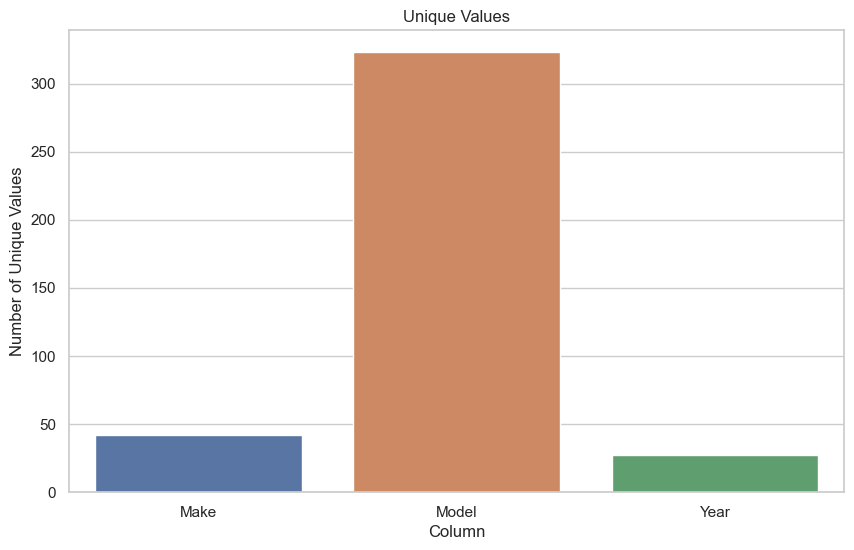

In [9]:
sns.set(style="whitegrid")

# Plotting unique values
plt.figure(figsize=(10, 6))
sns.barplot(x=['Make', 'Model', 'Year'], y=[make_unique, model_unique, year_unique])
plt.title('Unique Values')
plt.xlabel('Column')
plt.ylabel('Number of Unique Values')
plt.show()

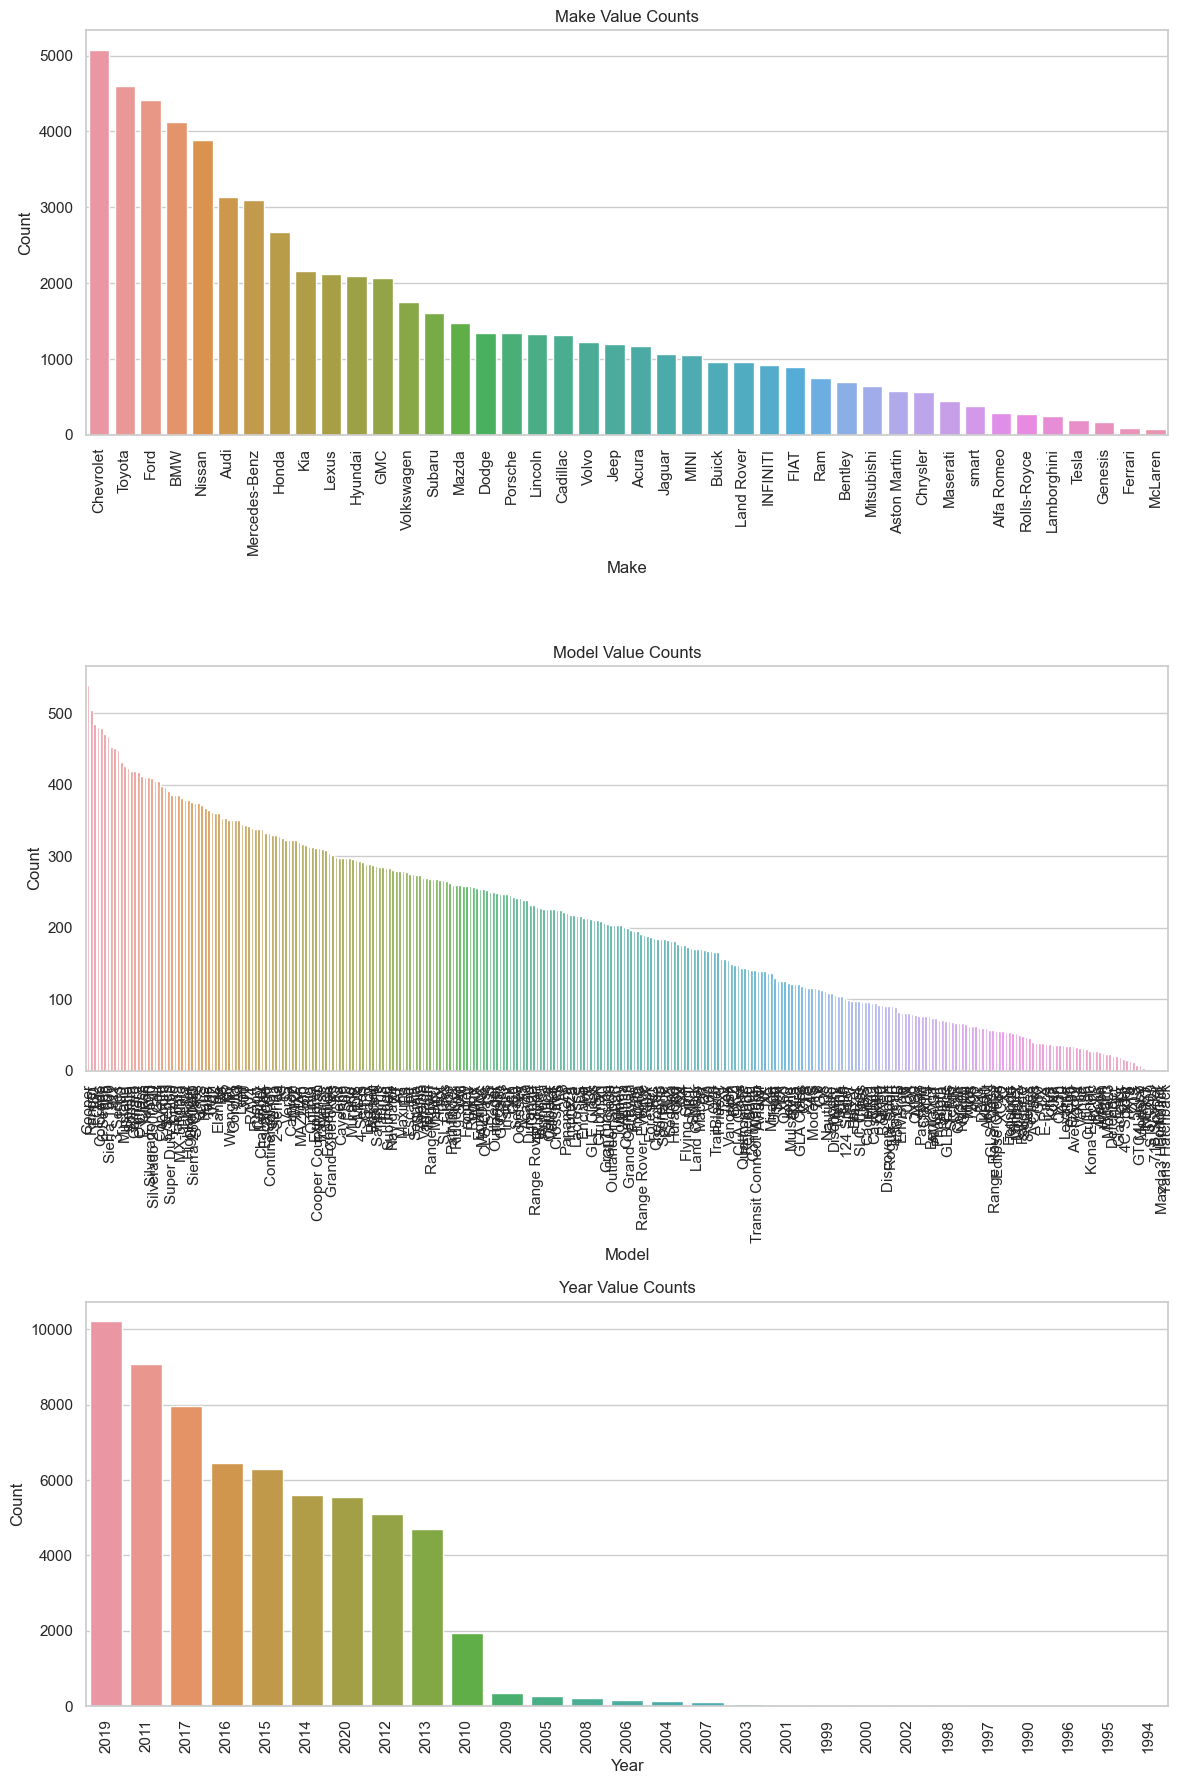

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Value counts for 'make'
sns.barplot(x=data['make'].value_counts().index, y=data['make'].value_counts().values, ax=axes[0])
axes[0].set_title('Make Value Counts')
axes[0].set_xlabel('Make')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Value counts for 'model'
sns.barplot(x=data['model'].value_counts().index, y=data['model'].value_counts().values, ax=axes[1])
axes[1].set_title('Model Value Counts')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

# Value counts for 'year'
sns.barplot(x=data['year'].value_counts().index, y=data['year'].value_counts().values, ax=axes[2])
axes[2].set_title('Year Value Counts')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# **Variables Configuration**

In [11]:
image_width, image_height = 240, 240
target = 'make'

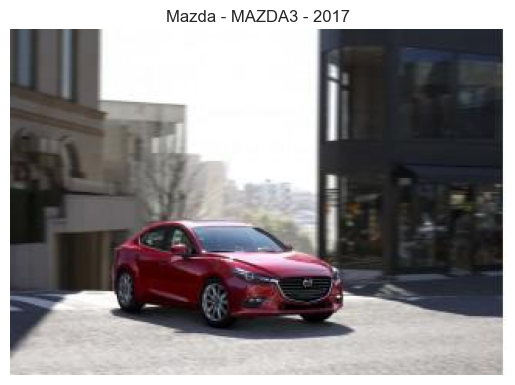

In [65]:
random_index = random.randint(0, len(data) - 1)
random_image = data.loc[random_index]
src = random_image.src

src = cv2.imread(f'{dataset_path}{src}', cv2.IMREAD_COLOR)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

plt.imshow(src)
plt.title(f'{random_image.make} - {random_image.model} - {random_image.year}')

plt.axis('off') 
plt.show()

# **Preprocessing**

In [66]:
def convert_image_to_arr(src):
    image = cv2.imread(dataset_path + src, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_width, image_height))

    return np.array(image)

data['images'] = data.src.apply(convert_image_to_arr)

# train_df, test_df = train_test_split(data, test_size=0.2, random_state=69, stratify=data['make'])
# X_train = np.array(train_df['src'].to_list()) 
# X_train
# # X_train = np.array(train_df['Image'].to_list()) / 255.0
# # X_test = np.array(test_df['Image'].to_list()) / 255.0

# # label_encoder = LabelEncoder()
# # y_train = label_encoder.fit_transform(train_df['Brand'])
# # y_test = label_encoder.transform(test_df['Brand'])

# **Prepare unseen data**

In [67]:
unique_test_samples = data.groupby(target).sample(n=1, random_state=69)
unique_test_df = unique_test_samples[['images', target]]
unique_test = np.array(unique_test_df['images'].to_list()) / 255.0
unique_answer = np.array(unique_test_df[target].to_list())
print(f"len before drop : {len(data)}")

data = data.drop(unique_test_samples.index)
print(f"len after drop : {len(data)}")

len before drop : 64467
len after drop : 64425


In [68]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=69, stratify=data[target])

X_train = np.array(train_df['images'].to_list()) / 255.0
X_test = np.array(test_df['images'].to_list()) / 255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df[target])
y_test = label_encoder.transform(test_df[target])

X_train

MemoryError: Unable to allocate 8.29 GiB for an array with shape (51540, 240, 240, 3) and data type uint8